In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import glob, os
%matplotlib inline  
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib.ticker as plticker


In [2]:
data = pd.read_csv("E0-E4_dataTable.csv",sep=",", header=0,
           dtype={"template_ID":str,"match":int,"template":str,"strandC":str,"strandR":str,"strandR_len":int,"strandC_len":int,"strand_align":str,"template_align":str})

In [3]:
# trim off the terminal C for both the template and the strandC
# assume that the terminal C is due to addition at the last cycle 

from re import sub

def encode_trimC(df):
    i=0
    strandR_len_trimmedC,strandR_trimmedC,strandC_trimmedC, strandC_len_trimmedC = [],[],[],[]
    
    for index, row in df.iterrows():
        text = row.strandR
        currstr = sub(r'(.)\1*', lambda m: ","+str(len(m.group(0)))+"," + m.group(1),text)
        currstr_tolist = currstr[1:].split(',')
        onlyNumbersString = currstr_tolist[::2]
        onlyNumbers = [int(x) for x in onlyNumbersString]
        onlyBasesString = currstr_tolist[1::2]
        onlyBases = [str(x) for x in onlyBasesString]

        if(onlyBases[-1]=='C'):
            onlyBases = onlyBases[:-1]
            onlyNumbers = onlyNumbers[:-1]

        strandR_trimmedC.append(text[0:sum(onlyNumbers)])
        strandR_len_trimmedC.append(sum(onlyNumbers))
        strandC_trimmedC.append(''.join(onlyBases))
        strandC_len_trimmedC.append(len(onlyBases))

    processed = [strandR_trimmedC,strandR_len_trimmedC,strandC_trimmedC,strandC_len_trimmedC]
    return processed

In [4]:
# after trimming the terminal C, add the data to the table

trimmed = encode_trimC(data)
data_withTrim = data
data_withTrim["strandR_trimmedC"] = trimmed[0]
data_withTrim["strandR_len_trimmedC"] = trimmed[1]
data_withTrim["strandC_trimmedC"] = trimmed[2]
data_withTrim["strandC_len_trimmedC"] = trimmed[3]
data_withTrim = data_withTrim[data_withTrim["strandR_len_trimmedC"]>0]

#release data variable
data = []

In [5]:
def bulkErrors_count(df):

    #to account for 0s
    matches = [0]*(18)
    mismatches = [0]*(18)
    deletions = [0]*(18)
    insertions = [0]*(18)
    
    num_analyzed = 0
    for index, row in df.iterrows():
        currMatches, currMismatches, currDeletions, currInsertions = 0,0,0,0
        template = row['template']
        template_aligned = list(row['template_align'])
        query_aligned = list(row['strandC_align'])

        # remove the terminal C 
        template_aligned = template_aligned[:-1]
        query_aligned = query_aligned[:-1]

        num_analyzed+=1
        for char_template, char_query in zip(template_aligned, query_aligned):
            action = ''  
            if((char_template == char_query) and ((char_query != '-') or (char_template != '-'))): #match
                currMatches+=1
                action = 'match'
            elif((char_template == '-') and (char_query !='-')):   #insertion           
                currInsertions+=1
                action = 'insertion'
            elif((char_template != char_query) and ((char_query != '-') and (char_template != '-'))): #mismatch if not deletion
                currMismatches+=1
                action = 'mismatch'
            elif((char_query == '-') and (char_template != '-')): #deletion in query
                currDeletions+=1
                action = 'deletion'
        matches[currMatches]+=1
        mismatches[currMismatches]+=1
        deletions[currDeletions]+=1
        insertions[currInsertions]+=1
        

    bulkData = {'matches':matches,'mismatches':mismatches,'deletions':deletions,'insertions':insertions, 'total':num_analyzed}
    return bulkData


In [6]:
E0 = data_withTrim[data_withTrim["template_ID"]=='E0']
E0_errors = bulkErrors_count(E0)

E0_Len2to3 = data_withTrim.loc[(data_withTrim["template_ID"]=='E0') & (data_withTrim["strandR_len"]>=32) & (data_withTrim["strandR_len"]<=48)]
E0_Len2to3_errors = bulkErrors_count(E0_Len2to3)

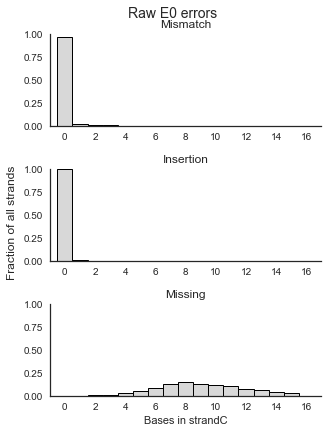

In [7]:
sns.set(font_scale=1)
sns.set_style("white")

numBases = list(range(0,18))

matches = E0_errors['matches']
matches_normalized = [entry/E0_errors['total'] for entry in matches]

mismatches = E0_errors['mismatches']
mismatches_normalized = [entry/E0_errors['total'] for entry in mismatches]

insertions = E0_errors['insertions']
insertions_normalized = [entry/E0_errors['total'] for entry in insertions]

deletions = E0_errors['deletions']
deletions_normalized = [entry/E0_errors['total'] for entry in deletions]

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(4.5,6))
axes_list = axes.flatten()
loc = plticker.MultipleLocator(base=2.0) 

axes_list[0].hist(numBases,bins=np.arange(19)-0.5,weights = mismatches_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[0].set_ylim(0,1)
axes_list[0].set_xlim(-1,17)
sns.despine(ax=axes_list[0])
axes_list[0].xaxis.set_major_locator(loc)
axes_list[0].set_title('Mismatch')


axes_list[1].hist(numBases,bins=np.arange(19)-0.5, weights = insertions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[1].set_ylim(0,1)
axes_list[1].set_xlim(-1,17)
sns.despine(ax=axes_list[1])
axes_list[1].xaxis.set_major_locator(loc)
axes_list[1].set_title('Insertion')

axes_list[2].hist(numBases,bins=np.arange(19)-0.5, weights = deletions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[2].set_ylim(0,1)
axes_list[2].set_xlim(-1,17)
sns.despine(ax=axes_list[2])
axes_list[2].xaxis.set_major_locator(loc)
axes_list[2].set_title('Missing')
axes_list[2].set_xlabel('Bases in strandC')

fig.text(-0.01, 0.5, 'Fraction of all strands', va='center', rotation='vertical')
fig.suptitle('Raw E0 errors', fontsize=14, y=1)

plt.tight_layout()
plt.savefig("E0_bulkerrors.pdf")

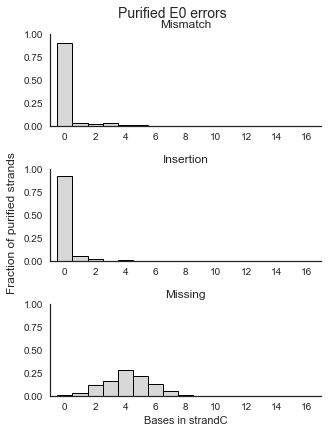

In [8]:
sns.set(font_scale=1)
sns.set_style("white")

numBases = list(range(0,18))

matches = E0_Len2to3_errors['matches']
matches_normalized = [entry/E0_Len2to3_errors['total'] for entry in matches]

mismatches = E0_Len2to3_errors['mismatches']
mismatches_normalized = [entry/E0_Len2to3_errors['total'] for entry in mismatches]

insertions = E0_Len2to3_errors['insertions']
insertions_normalized = [entry/E0_Len2to3_errors['total'] for entry in insertions]

deletions = E0_Len2to3_errors['deletions']
deletions_normalized = [entry/E0_Len2to3_errors['total'] for entry in deletions]

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(4.5,6))
axes_list = axes.flatten()
loc = plticker.MultipleLocator(base=2.0) 

axes_list[0].hist(numBases,bins=np.arange(19)-0.5,weights = mismatches_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[0].set_ylim(0,1)
axes_list[0].set_xlim(-1,17)
sns.despine(ax=axes_list[0])
axes_list[0].xaxis.set_major_locator(loc)
axes_list[0].set_title('Mismatch')


axes_list[1].hist(numBases,bins=np.arange(19)-0.5, weights = insertions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[1].set_ylim(0,1)
axes_list[1].set_xlim(-1,17)
sns.despine(ax=axes_list[1])
axes_list[1].xaxis.set_major_locator(loc)
axes_list[1].set_title('Insertion')

axes_list[2].hist(numBases,bins=np.arange(19)-0.5, weights = deletions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[2].set_ylim(0,1)
axes_list[2].set_xlim(-1,17)
sns.despine(ax=axes_list[2])
axes_list[2].xaxis.set_major_locator(loc)
axes_list[2].set_title('Missing')
axes_list[2].set_xlabel('Bases in strandC')

fig.text(-0.01, 0.5, 'Fraction of purified strands', va='center', rotation='vertical')
fig.suptitle('Purified E0 errors', fontsize=14, y=1)

plt.tight_layout()
plt.savefig("E0_Len2t03_bulkerrors.pdf")


In [9]:
import editdistance

def calcEditDistances(df):
    temp = df.head(1)
    numEdits = temp["template"].str.len().values[0]
    
    edits_dist = [0]*numEdits
    for _, row in df.iterrows():
        template = row['template']
        template = template[:-1] #remove the terminal C
        query = row['strandC_trimmedC']
        dist = editdistance.eval(template,query)
        edits_dist[dist]+=1

    return edits_dist

In [10]:
def getCompressedLen(df):
    numBins = df["strandC_len_trimmedC"].max()+1    
    compressedLens = [0]*int(numBins)
    for _, row in df.iterrows():
        curr_compressedlen = int(row["strandC_len_trimmedC"])
        compressedLens[curr_compressedlen]+=1

    return compressedLens

In [11]:
def getStats(df, minCount):
    stats = {}
    df_seqs = df["strandC_trimmedC"].value_counts()
    df_seqs_gt_uniq = df_seqs[df_seqs>=minCount].index.tolist()
    df_seqs_gt = df[df["strandC_trimmedC"].isin(df_seqs_gt_uniq)]

    compressedLens_df_seqs_gt = getCompressedLen(df_seqs_gt)

    diverselens_df = [0]*20
    for seq in df_seqs_gt_uniq:
        diverselens_df[len(seq)]+=1

    edits_df = [0]*18
    template = df.iloc[0].template[:-1] #remove the terminal C
    for seq in df_seqs_gt_uniq:
        dist = editdistance.eval(template,seq)
        edits_df[dist]+=1
        
    stats = {'lens':compressedLens_df_seqs_gt, 'diversity': diverselens_df, 'edits': edits_df}
    return stats

In [12]:
E0_stats = getStats(E0,2)
E0_Len2to3_stats = getStats(E0_Len2to3,2)

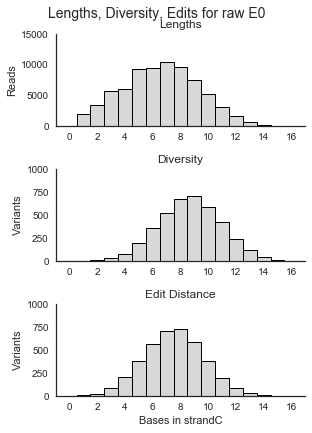

In [13]:
# plot lengths, diversity, and edit distance for raw E0
sns.set(font_scale=1)
plt.rcParams['font.sans-serif'] = 'Myriad Pro'

sns.set_style("white")

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(4.5,6))
axes_list = axes.flatten()

xloc = plticker.MultipleLocator(base=2.0) 
yloc = plticker.MultipleLocator(base=250.0) 
yloc2 = plticker.MultipleLocator(base=5000.0) 

numLens = list(range(0,len(E0_stats["lens"])))
axes_list[0].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = E0_stats["lens"], edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[0].xaxis.set_major_locator(xloc)
axes_list[0].yaxis.set_major_locator(yloc2)
axes_list[0].set_xlim(-1,17)
axes_list[0].set_ylim(0,15000)
axes_list[0].set_title('Lengths')
axes_list[0].set_ylabel('Reads')
sns.despine(ax=axes_list[0])

numLens = list(range(0,len(E0_stats["diversity"])))
axes_list[1].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = E0_stats["diversity"], edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[1].xaxis.set_major_locator(xloc)
axes_list[1].yaxis.set_major_locator(yloc)
axes_list[1].set_xlim(-1,17)
axes_list[1].set_ylim(0,1000)
axes_list[1].set_title('Diversity')
axes_list[1].set_ylabel('Variants')
sns.despine(ax=axes_list[1])

numEdits = list(range(0,len(E0_stats["edits"])))
axes_list[2].hist(numEdits,bins=np.arange(len(numLens))-0.5, weights = E0_stats["edits"], edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[2].xaxis.set_major_locator(xloc)
axes_list[2].yaxis.set_major_locator(yloc)
axes_list[2].set_xlim(-1,17)
axes_list[2].set_ylim(0,1000)
axes_list[2].set_title('Edit Distance')
axes_list[2].set_xlabel('Bases in strandC')
axes_list[2].set_ylabel('Variants')

sns.despine(ax=axes_list[2])
fig.suptitle('Lengths, Diversity, Edits for raw E0', fontsize=14, y=1)
plt.tight_layout()
plt.savefig("E0_raw_Len_Div_Edits.pdf")



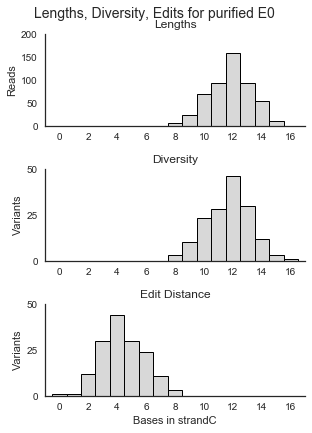

In [14]:
# plot lengths, diversity, and edit distance for purified E0
sns.set(font_scale=1)
plt.rcParams['font.sans-serif'] = 'Myriad Pro'

sns.set_style("white")

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(4.5,6))
axes_list = axes.flatten()

xloc = plticker.MultipleLocator(base=2.0) 
yloc = plticker.MultipleLocator(base=25.0) 
yloc2 = plticker.MultipleLocator(base=50.0) 

numLens = list(range(0,len(E0_Len2to3_stats["lens"])))
axes_list[0].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = E0_Len2to3_stats["lens"], edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[0].xaxis.set_major_locator(xloc)
axes_list[0].yaxis.set_major_locator(yloc2)
axes_list[0].set_xlim(-1,17)
axes_list[0].set_ylim(0,200)
axes_list[0].set_title('Lengths')
axes_list[0].set_ylabel('Reads')
sns.despine(ax=axes_list[0])

numLens = list(range(0,len(E0_Len2to3_stats["diversity"])))
axes_list[1].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = E0_Len2to3_stats["diversity"], edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[1].xaxis.set_major_locator(xloc)
axes_list[1].yaxis.set_major_locator(yloc)
axes_list[1].set_xlim(-1,17)
axes_list[1].set_ylim(0,50)
axes_list[1].set_title('Diversity')
axes_list[1].set_ylabel('Variants')
sns.despine(ax=axes_list[1])

numEdits = list(range(0,len(E0_Len2to3_stats["edits"])))
axes_list[2].hist(numEdits,bins=np.arange(len(numLens))-0.5, weights = E0_Len2to3_stats["edits"], edgecolor='black', linewidth=1,color='#D8D8D8')
axes_list[2].xaxis.set_major_locator(xloc)
axes_list[2].yaxis.set_major_locator(yloc)
axes_list[2].set_xlim(-1,17)
axes_list[2].set_ylim(0,50)
axes_list[2].set_title('Edit Distance')
axes_list[2].set_xlabel('Bases in strandC')
axes_list[2].set_ylabel('Variants')

sns.despine(ax=axes_list[2])
fig.suptitle('Lengths, Diversity, Edits for purified E0 ', fontsize=14, y=1)

plt.tight_layout()
plt.savefig("E0_purified_Len_Div_Edits.pdf")

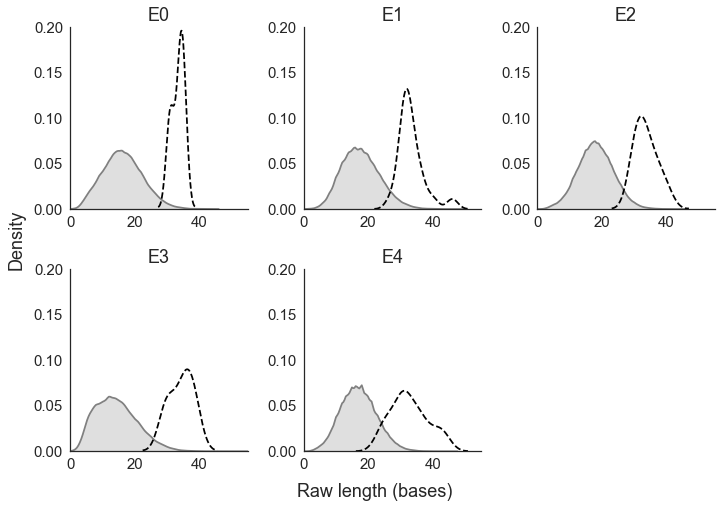

In [15]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set(font_scale=1.5, style="white")

strands = ['E0','E1','E2','E3','E4']

fig, ax = plt.subplots()
fig.set_size_inches(10, 7) 

plotnum = 1
for i in strands:
    currSample = data_withTrim.loc[data_withTrim["template_ID"]==i]
    rawlengths = currSample["strandR_len"].astype("float")
    matches = currSample.loc[currSample["match"]==1, "strandR_len"].astype("float")
    
    plt.subplot(2, 3, plotnum)
    plotnum+=1
    g=sns.kdeplot(rawlengths,color="gray",shade=True)
    g=sns.kdeplot(matches,color="black",linestyle='dashed')

    g.legend_.remove()
    g.set(xlim=(0, 55))
    g.set(ylim=(0, 0.2))
    g.set(title=i)
    g.tick_params(which='both',bottom='off',left='off',right='off',top='off')
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)

fig.text(0.5, -0.01, 'Raw length (bases)', ha='center')
fig.text(-0.01, 0.5, 'Density', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig('Eureka_lengthdist.pdf')

In [16]:
E1_raw = data_withTrim.loc[(data_withTrim["template_ID"]=='E1') & (data_withTrim["strandC_len_trimmedC"]>0)]
E2_raw = data_withTrim.loc[(data_withTrim["template_ID"]=='E2') & (data_withTrim["strandC_len_trimmedC"]>0)]
E3_raw = data_withTrim.loc[(data_withTrim["template_ID"]=='E3') & (data_withTrim["strandC_len_trimmedC"]>0)]
E4_raw = data_withTrim.loc[(data_withTrim["template_ID"]=='E4') & (data_withTrim["strandC_len_trimmedC"]>0)]

E1_errors = bulkErrors_count(E1_raw)
E2_errors = bulkErrors_count(E2_raw)
E3_errors = bulkErrors_count(E3_raw)
E4_errors = bulkErrors_count(E4_raw)

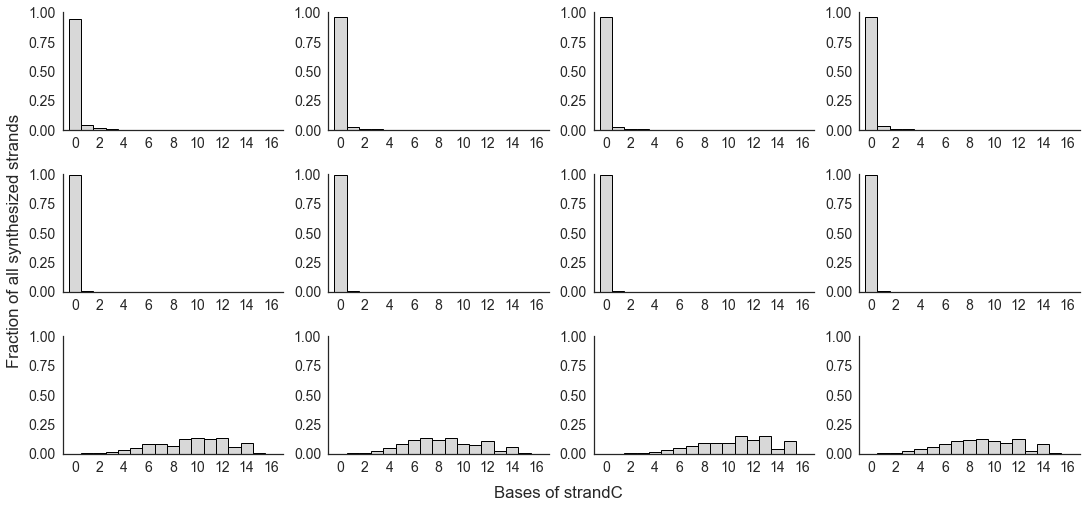

In [17]:
## plot the errors for the raw strands of E1-E4 (columns)
## rows will be mismatches, insertions, and deletions (missing)

plt.rcParams['figure.figsize'] = 8,8
sns.set(font_scale=1.4)
sns.set_style("white")

numBases = list(range(0,18))

errors_to_plot = [E1_errors, E2_errors, E3_errors, E4_errors]

fig, axes = plt.subplots(nrows=3, ncols=len(errors_to_plot), sharex=False, sharey=False, figsize=(15,7))
axes_list = axes.flatten()
i=0

loc = plticker.MultipleLocator(base=2.0) 

for strands in errors_to_plot:
    
    curr_mismatches = strands['mismatches']
    curr_mismatches_normalized = [entry/strands['total'] for entry in curr_mismatches]

    curr_insertions = strands['insertions']
    curr_insertions_normalized = [entry/strands['total'] for entry in curr_insertions]

    curr_deletions = strands['deletions']
    curr_deletions_normalized = [entry/strands['total'] for entry in curr_deletions]

    axes_list[i+2*len(errors_to_plot)].hist(numBases,bins=np.arange(19)-0.5, weights = curr_deletions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+2*len(errors_to_plot)].set_ylim(0,1)
    axes_list[i+2*len(errors_to_plot)].set_xlim(-1,17)
    axes_list[i+2*len(errors_to_plot)].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i+2*len(errors_to_plot)])
    axes_list[i+2*len(errors_to_plot)].xaxis.set_major_locator(loc)

    axes_list[i].hist(numBases,bins=np.arange(19)-0.5, weights = curr_mismatches_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i].set_ylim(0,1)
    axes_list[i].set_xlim(-1,17)
    axes_list[i].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i])
    axes_list[i].xaxis.set_major_locator(loc)


    axes_list[i+1*len(errors_to_plot)].hist(numBases,bins=np.arange(19)-0.5, weights = curr_insertions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+1*len(errors_to_plot)].set_ylim(0,1)
    axes_list[i+1*len(errors_to_plot)].set_xlim(-1,17)
    axes_list[i+1*len(errors_to_plot)].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i+1*len(errors_to_plot)])
    axes_list[i+1*len(errors_to_plot)].xaxis.set_major_locator(loc)

    i+=1

fig.text(0.5, -0.01, 'Bases of strandC', ha='center')
fig.text(-0.01, 0.5, 'Fraction of all synthesized strands', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig("Eureka_raw_errors.pdf")


In [18]:
E1_Len2to3 = data_withTrim.loc[(data_withTrim["template_ID"]=='E1') & (data_withTrim["strandR_len"]>=32) & (data_withTrim["strandR_len"]<=48)]
E2_Len2to3 = data_withTrim.loc[(data_withTrim["template_ID"]=='E2') & (data_withTrim["strandR_len"]>=32) & (data_withTrim["strandR_len"]<=48)]
E3_Len2to3 = data_withTrim.loc[(data_withTrim["template_ID"]=='E3') & (data_withTrim["strandR_len"]>=32) & (data_withTrim["strandR_len"]<=48)]
E4_Len2to3 = data_withTrim.loc[(data_withTrim["template_ID"]=='E4') & (data_withTrim["strandR_len"]>=32) & (data_withTrim["strandR_len"]<=48)]

E1_Len2to3_errors = bulkErrors_count(E1_Len2to3)
E2_Len2to3_errors = bulkErrors_count(E2_Len2to3)
E3_Len2to3_errors = bulkErrors_count(E3_Len2to3)
E4_Len2to3_errors = bulkErrors_count(E4_Len2to3)

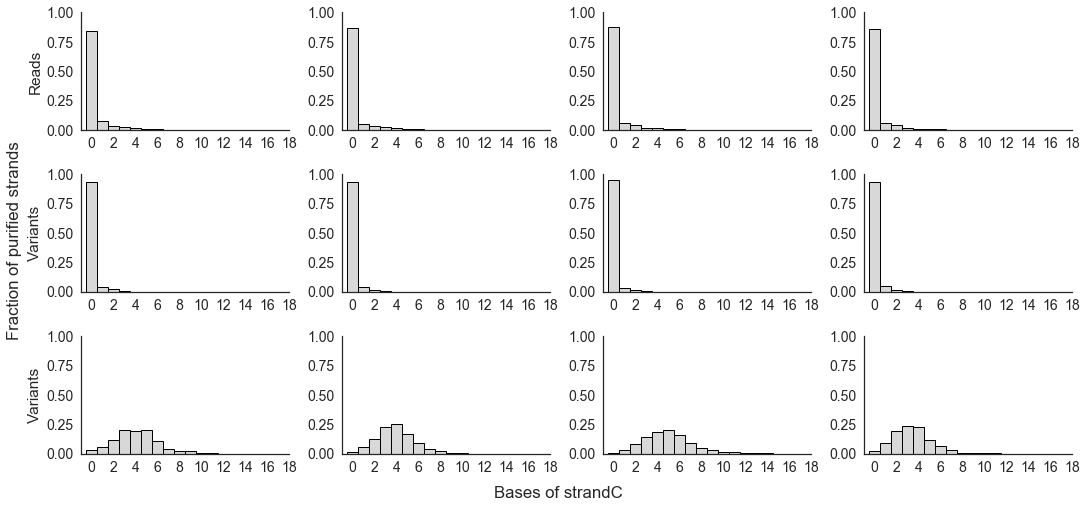

In [19]:
## plot the errors for the purified strands of E1-E4 (columns)
## rows will be mismatches, insertions, and deletions (missing)

plt.rcParams['figure.figsize'] = 8,8
sns.set(font_scale=1.4)
sns.set_style("white")

numBases = list(range(0,18))

errors_to_plot = [E1_Len2to3_errors, E2_Len2to3_errors, E3_Len2to3_errors, E4_Len2to3_errors]

fig, axes = plt.subplots(nrows=3, ncols=len(errors_to_plot), sharex=False, sharey=False, figsize=(15,7))
axes_list = axes.flatten()
i=0

loc = plticker.MultipleLocator(base=2.0)

for strands in errors_to_plot:

    curr_mismatches = strands['mismatches']
    curr_mismatches_normalized = [entry/strands['total'] for entry in curr_mismatches]

    curr_insertions = strands['insertions']
    curr_insertions_normalized = [entry/strands['total'] for entry in curr_insertions]

    curr_deletions = strands['deletions']
    curr_deletions_normalized = [entry/strands['total'] for entry in curr_deletions]
    
    axes_list[i].hist(numBases,bins=np.arange(19)-0.5, weights = curr_mismatches_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i].set_ylim(0,1)
    axes_list[i].set_xlim(-1,18)
    axes_list[i].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i])
    axes_list[i].xaxis.set_major_locator(loc)
    if(i==0):
        axes_list[i].set_ylabel('Reads')

    axes_list[i+1*len(errors_to_plot)].hist(numBases,bins=np.arange(19)-0.5, weights = curr_insertions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+1*len(errors_to_plot)].set_ylim(0,1)
    axes_list[i+1*len(errors_to_plot)].set_xlim(-1,18)
    axes_list[i+1*len(errors_to_plot)].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i+1*len(errors_to_plot)])
    axes_list[i+1*len(errors_to_plot)].xaxis.set_major_locator(loc)
    if(i==0):
        axes_list[i+1*len(errors_to_plot)].set_ylabel('Variants')

    axes_list[i+2*len(errors_to_plot)].hist(numBases,bins=np.arange(19)-0.5, weights = curr_deletions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+2*len(errors_to_plot)].set_ylim(0,1)
    axes_list[i+2*len(errors_to_plot)].set_xlim(-1,18)
    axes_list[i+2*len(errors_to_plot)].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i+2*len(errors_to_plot)])
    axes_list[i+2*len(errors_to_plot)].xaxis.set_major_locator(loc)
    if(i==0):
        axes_list[i+2*len(errors_to_plot)].set_ylabel('Variants')

    
    i+=1
    
fig.text(0.5, -0.01, 'Bases of strandC', ha='center')
fig.text(-0.01, 0.5, 'Fraction of purified strands', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig("Eureka_purified_errors.pdf")


In [20]:
E1_raw_stats = getStats(E1_raw,2)
E2_raw_stats = getStats(E2_raw,2)
E3_raw_stats = getStats(E3_raw,2)
E4_raw_stats = getStats(E4_raw,2)

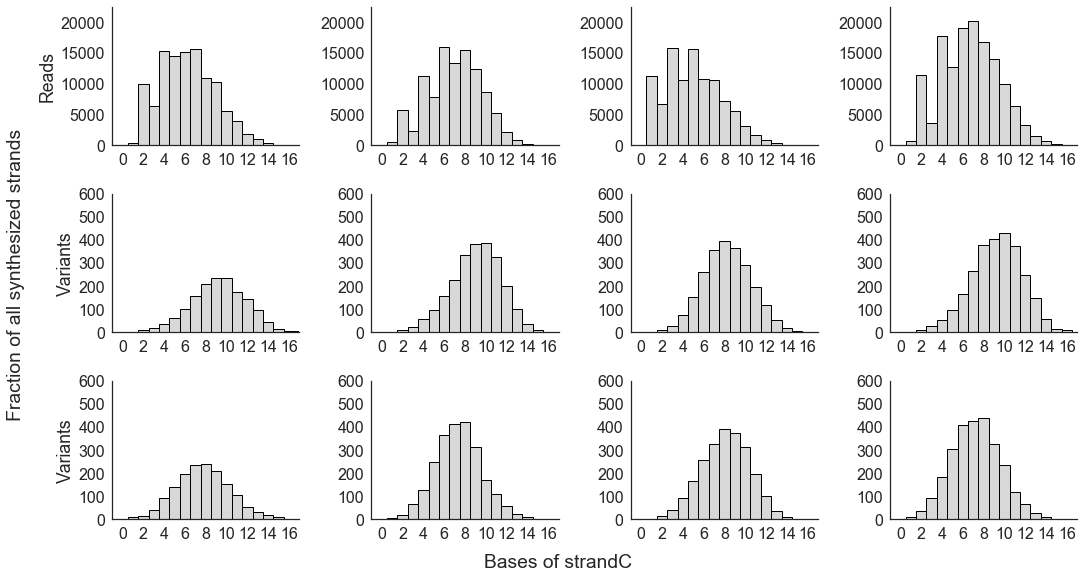

In [21]:
## plot the lengths, diversity, and edit distance for the raw strands of E1-E4 (columns)
## rows will be lengths (reads), diversity (number of variants), and edit distances (number of variants)

plt.rcParams['figure.figsize'] = 8,8
sns.set(font_scale=1.6)
plt.rcParams['font.sans-serif'] = 'Myriad Pro'
sns.set_style("white")

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=False, sharey=False, figsize=(15,8))
axes_list = axes.flatten()

xloc = plticker.MultipleLocator(base=2.0) 
yloc = plticker.MultipleLocator(base=100.0) 
yloc2 = plticker.MultipleLocator(base=5000.0) 

to_plot = [E1_raw_stats,E2_raw_stats,E3_raw_stats,E4_raw_stats]

i=0
for strands in to_plot:
    
    numLens = list(range(0,len(strands["lens"])))
    axes_list[i].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = strands["lens"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i].xaxis.set_major_locator(xloc)
    axes_list[i].yaxis.set_major_locator(yloc2)
    axes_list[i].set_xlim(-1,17)
    axes_list[i].set_ylim(0,22500)
    sns.despine(ax=axes_list[i])
    if(i==0):
        axes_list[i].set_ylabel('Reads')

    numLens = list(range(0,len(strands["diversity"])))
    axes_list[i+1*len(to_plot)].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = strands["diversity"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+1*len(to_plot)].xaxis.set_major_locator(xloc)
    axes_list[i+1*len(to_plot)].yaxis.set_major_locator(yloc)
    axes_list[i+1*len(to_plot)].set_xlim(-1,17)
    axes_list[i+1*len(to_plot)].set_ylim(0,600)
    sns.despine(ax=axes_list[i+1*len(to_plot)])
    if(i==0):
        axes_list[i+1*len(to_plot)].set_ylabel('Variants')

    numEdits = list(range(0,len(strands["edits"])))
    axes_list[i+2*len(to_plot)].hist(numEdits,bins=np.arange(len(numLens))-0.5, weights = strands["edits"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+2*len(to_plot)].xaxis.set_major_locator(xloc)
    axes_list[i+2*len(to_plot)].yaxis.set_major_locator(yloc)
    axes_list[i+2*len(to_plot)].set_xlim(-1,17)
    axes_list[i+2*len(to_plot)].set_ylim(0,600)
    sns.despine(ax=axes_list[i+2*len(to_plot)])
    if(i==0):
        axes_list[i+2*len(to_plot)].set_ylabel('Variants')

    i+=1

fig.text(0.5, -0.01, 'Bases of strandC', ha='center')
fig.text(-0.01, 0.5, 'Fraction of all synthesized strands', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig("E1-E4_raw_Lens_Div_Edits.pdf")


In [22]:
E1_Len2to3_stats = getStats(E1_Len2to3, 2)
E2_Len2to3_stats = getStats(E2_Len2to3, 2)
E3_Len2to3_stats = getStats(E3_Len2to3, 2)
E4_Len2to3_stats = getStats(E4_Len2to3, 2)

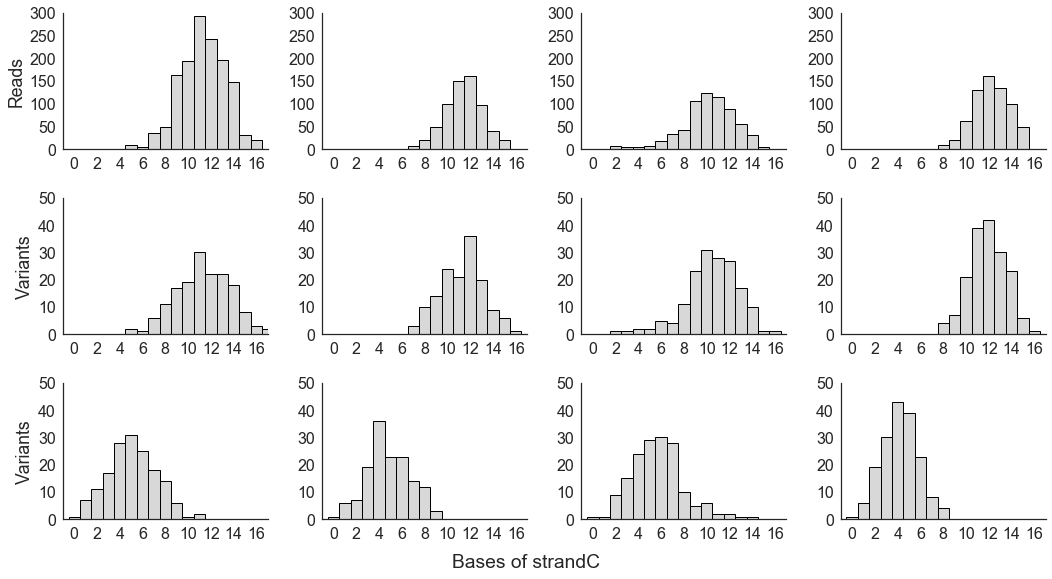

In [23]:
## plot the lengths, diversity, and edit distance for the purified strands of E1-E4 (columns)
## rows will be lengths (reads), diversity (number of variants), and edit distances (number of variants)

plt.rcParams['figure.figsize'] = 8,8
sns.set(font_scale=1.6)
plt.rcParams['font.sans-serif'] = 'Myriad Pro'
sns.set_style("white")

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=False, sharey=False, figsize=(15,8))
axes_list = axes.flatten()

xloc = plticker.MultipleLocator(base=2.0) 
yloc = plticker.MultipleLocator(base=10.0) 
yloc2 = plticker.MultipleLocator(base=50.0) 

to_plot = [E1_Len2to3_stats,E2_Len2to3_stats,E3_Len2to3_stats,E4_Len2to3_stats]

i=0
for strands in to_plot:
    
    numLens = list(range(0,len(strands["lens"])))
    axes_list[i].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = strands["lens"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i].xaxis.set_major_locator(xloc)
    axes_list[i].yaxis.set_major_locator(yloc2)
    axes_list[i].set_xlim(-1,17)
    axes_list[i].set_ylim(0,300)
    sns.despine(ax=axes_list[i])
    if(i==0):
        axes_list[i].set_ylabel('Reads')


    numLens = list(range(0,len(strands["diversity"])))
    axes_list[i+1*len(to_plot)].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = strands["diversity"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+1*len(to_plot)].xaxis.set_major_locator(xloc)
    axes_list[i+1*len(to_plot)].yaxis.set_major_locator(yloc)
    axes_list[i+1*len(to_plot)].set_xlim(-1,17)
    axes_list[i+1*len(to_plot)].set_ylim(0,50)
    sns.despine(ax=axes_list[i+1*len(to_plot)])
    if(i==0):
        axes_list[i+1*len(to_plot)].set_ylabel('Variants')


    numEdits = list(range(0,len(strands["edits"])))
    axes_list[i+2*len(to_plot)].hist(numEdits,bins=np.arange(len(numLens))-0.5, weights = strands["edits"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+2*len(to_plot)].xaxis.set_major_locator(xloc)
    axes_list[i+2*len(to_plot)].yaxis.set_major_locator(yloc)
    axes_list[i+2*len(to_plot)].set_xlim(-1,17)
    axes_list[i+2*len(to_plot)].set_ylim(0,50)
    sns.despine(ax=axes_list[i+2*len(to_plot)])
    if(i==0):
        axes_list[i+2*len(to_plot)].set_ylabel('Variants')

    i+=1

fig.text(0.5, -0.01, 'Bases of strandC', ha='center')
plt.tight_layout()
plt.savefig("E1-E4_purified_Lens_Div_Edits.pdf")


In [24]:
# output purified strands used for MAP decoding

E1_Len2to3_seqs = E1_Len2to3["strandC_trimmedC"].value_counts()
E1_Len2to3_gt2Diversity = E1_Len2to3_seqs[E1_Len2to3_seqs>=2].index.tolist()

E2_Len2to3_seqs = E2_Len2to3["strandC_trimmedC"].value_counts()
E2_Len2to3_gt2Diversity = E2_Len2to3_seqs[E2_Len2to3_seqs>=2].index.tolist()

E3_Len2to3_seqs = E3_Len2to3["strandC_trimmedC"].value_counts()
E3_Len2to3_gt2Diversity = E3_Len2to3_seqs[E3_Len2to3_seqs>=2].index.tolist()

E4_Len2to3_seqs = E4_Len2to3["strandC_trimmedC"].value_counts()
E4_Len2to3_gt2Diversity = E4_Len2to3_seqs[E4_Len2to3_seqs>=2].index.tolist()


In [25]:
E1_Len2to3_seqs.to_csv("E1_Len2to3.txt")
E2_Len2to3_seqs.to_csv("E2_Len2to3.txt")
E3_Len2to3_seqs.to_csv("E3_Len2to3.txt")
E4_Len2to3_seqs.to_csv("E4_Len2to3.txt")